In [8]:
import os
from pathlib import Path
import sys
import time
from functools import partial
from tqdm import tqdm
import copy
import  random

from pprint import pprint

pwd = Path(os.getcwd())
sys.path.append(str(pwd.parent.parent / "gym-checkers-for-thai"))

In [9]:
from checkers.agents.baselines import play_a_game, RandomPlayer
from checkers.game import Checkers
from checkers.agents import Player
from checkers.agents.alpha_beta import MinimaxPlayer, first_order_adv

from player import GDQLPlayer
from model import GDQL

import mlflow
import mlflow.pytorch

import matplotlib.pyplot as plt
import seaborn as sns

import torch

import numpy as np

In [10]:
MINIMAX_SEARCH_DEPTH = 3
WEIGHT_FOLDER = pwd / "weights" / f"vs_depth_{MINIMAX_SEARCH_DEPTH}"

N_EPISODES = 10
N_MATCHES_PER_EPS = 20

REWARD_DISCOUNT_FACTOR = 0.9

EPSILON = 0.8
EPSILON_DECAY_FACTOR = 0.999
EPSILON_MIN = 0.05

BATCH_SIZE = 128

TARGET_UPDATE = 2 # update target network every TARGET_UPDATE episodes
LEARNING_RATE = 0.01

In [11]:
# Create the folder if it doesn't exist
WEIGHT_FOLDER.mkdir(parents=True, exist_ok=True)

In [12]:
loss_hist = []

In [13]:
online_model = GDQL(lr=LEARNING_RATE)
target_model = GDQL(lr=LEARNING_RATE)
try:
    online_model.load_state_dict(torch.load(WEIGHT_FOLDER / "online_model.pth"))
    target_model.load_state_dict(torch.load(WEIGHT_FOLDER / "target_model.pth"))
except FileNotFoundError:
    print("No weights found, starting from scratch")

for episode in range(N_EPISODES):
    n_wins, n_losses, n_draws = 0, 0, 0
    looper = tqdm(range(N_MATCHES_PER_EPS), unit="matches", leave=True, desc=f"Episode {episode+1}")
    for i in looper:
        ch = Checkers()

        black_player = GDQLPlayer('black',
                                model=online_model,
                                epsilon=EPSILON,
                                epsilon_decay=EPSILON_DECAY_FACTOR,
                                epsilon_min=EPSILON_MIN,)

        if MINIMAX_SEARCH_DEPTH == 0:
            # Random player function
            white_player = RandomPlayer('white', seed=i)
        else:
            # Minimax player function
            white_player = MinimaxPlayer('white', 
                                        partial(first_order_adv, 'white', 86, 54.5, 87, 26),
                                        search_depth=MINIMAX_SEARCH_DEPTH)
        
        # push into environment
        winner = play_a_game(ch, black_player.next_move, white_player.next_move, 100, is_show_detail=False)
        if winner == 'black':
            n_wins += 1
        elif winner == 'white':
            n_losses += 1
        else:
            n_draws += 1

        if len(GDQLPlayer.experience) > BATCH_SIZE:
            batch_states = random.sample(GDQLPlayer.experience, BATCH_SIZE)
            
            # find target, online Q values and compute loss
            loss = 0
            for i, (state, action, reward, next_state) in enumerate(batch_states):
                online_model.train()
                target_model.eval()

                # find target Q
                if next_state is not None:
                    max_next_state_value = -np.inf
                    ch.restore_state(state)
                    available_actions = ch.legal_moves()
                    for available_action in available_actions:
                        model_input = target_model.board2input(next_state[0], 'black', available_action)
                        next_state_value = target_model(model_input)
                        max_next_state_value = max(max_next_state_value, next_state_value)
                    target_q = reward + max_next_state_value * REWARD_DISCOUNT_FACTOR
                else:
                    target_q = reward

                # find online Q
                model_input = online_model.board2input(state[0], 'black', action)
                online_q = online_model(model_input)

                loss += (online_q - target_q) ** 2
            loss /= BATCH_SIZE
            looper.set_postfix(loss=loss.item())

            # compute loss
            online_model.optimizer.zero_grad()
            loss.backward()
            online_model.optimizer.step()

            loss_hist.append(loss.item())

    if episode % TARGET_UPDATE == 0:
        target_model.load_state_dict(online_model.state_dict())
        print("\tTarget model updated")
    print(f"\tWins: {n_wins}, Losses: {n_losses}, Draws: {n_draws}")

No weights found, starting from scratch


Episode 1:   0%|          | 0/20 [00:00<?, ?matches/s]

Episode 1: 100%|██████████| 20/20 [00:26<00:00,  1.31s/matches, loss=367]


	Target model updated
	Wins: 0, Losses: 20, Draws: 0


Episode 2: 100%|██████████| 20/20 [00:25<00:00,  1.29s/matches, loss=377]   


	Wins: 0, Losses: 20, Draws: 0


Episode 3: 100%|██████████| 20/20 [00:24<00:00,  1.24s/matches, loss=242]


	Target model updated
	Wins: 0, Losses: 20, Draws: 0


Episode 4: 100%|██████████| 20/20 [00:25<00:00,  1.28s/matches, loss=430]


	Wins: 0, Losses: 20, Draws: 0


Episode 5: 100%|██████████| 20/20 [00:25<00:00,  1.26s/matches, loss=359]


	Target model updated
	Wins: 0, Losses: 20, Draws: 0


Episode 6: 100%|██████████| 20/20 [00:25<00:00,  1.29s/matches, loss=1.34e+3]


	Wins: 0, Losses: 20, Draws: 0


Episode 7: 100%|██████████| 20/20 [00:26<00:00,  1.33s/matches, loss=761]   


	Target model updated
	Wins: 0, Losses: 20, Draws: 0


Episode 8: 100%|██████████| 20/20 [00:25<00:00,  1.26s/matches, loss=462]


	Wins: 0, Losses: 20, Draws: 0


Episode 9: 100%|██████████| 20/20 [00:25<00:00,  1.28s/matches, loss=366]


	Target model updated
	Wins: 0, Losses: 20, Draws: 0


Episode 10: 100%|██████████| 20/20 [00:25<00:00,  1.28s/matches, loss=496]

	Wins: 0, Losses: 20, Draws: 0


<Axes: >

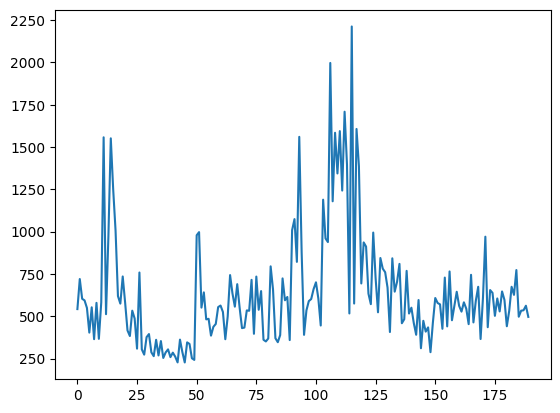

In [15]:
sns.lineplot(x=range(len(loss_hist[10:])), y=loss_hist[10:])

In [39]:
ch = Checkers()

black_player = GDQLPlayer('black',
                                model=online_model,
                                epsilon=EPSILON,
                                epsilon_decay=EPSILON_DECAY_FACTOR,
                                epsilon_min=EPSILON_MIN,)
# Random player function
white_player = RandomPlayer('white', seed=i)
        
# push into environment
winner = play_a_game(ch, black_player.next_move, white_player.next_move, 100, is_show_detail=True)

_b_b_b_b
b_b_b_b_
_._._._.
._._._._
_._._._.
._._._._
_w_w_w_w
w_w_w_w_
0 turn: black last_moved_piece: None
7 legal moves [(4, 8), (5, 8), (5, 9), (6, 9), (6, 10), (7, 10), (7, 11)]
black moved 5, 8

_b_b_b_b
b_._b_b_
_b_._._.
._._._._
_._._._.
._._._._
_w_w_w_w
w_w_w_w_
1 turn: white last_moved_piece: None
7 legal moves [(24, 21), (24, 20), (25, 22), (25, 21), (26, 23), (26, 22), (27, 23)]
white moved 24, 20

_b_b_b_b
b_._b_b_
_b_._._.
._._._._
_._._._.
w_._._._
_._w_w_w
w_w_w_w_
2 turn: black last_moved_piece: None
8 legal moves [(0, 5), (1, 5), (6, 9), (6, 10), (7, 10), (7, 11), (8, 12), (8, 13)]
black moved 8, 12

_b_b_b_b
b_._b_b_
_._._._.
b_._._._
_._._._.
w_._._._
_._w_w_w
w_w_w_w_
3 turn: white last_moved_piece: None
8 legal moves [(20, 16), (25, 22), (25, 21), (26, 23), (26, 22), (27, 23), (28, 24), (29, 24)]
white moved 26, 22

_b_b_b_b
b_._b_b_
_._._._.
b_._._._
_._._._.
w_._w_._
_._w_._w
w_w_w_w_
4 turn: black last_moved_piece: None
8 legal moves [(0, 5), (1, 5), (4, 8), (